# A Quantum Auto-Encoder based on Parametric Quantum Circuit for anomaly detection of MNIST images
## Tutorial - Hands-on ##

**Version:** V3.1 <p>
**Authors:** Stefano Giagu <stefano.giagu@uniroma1.it>


**Scope:**: learn how to design a simple variational PQC and train it for a anomaly detection task using the [pennylane](https://pennylane.ai/) platform with [pytorch](https://pytorch.org/) backend

**Libraries:** numpy, matplotlib, pennylane, torch

In [1]:
# only needed on google colab
#!pip install pennylane-lightning-gpu

In [2]:
# import needed libraries
import matplotlib.pyplot as plt
import os
from time import time
from tqdm import tqdm

import torch
from torch.autograd import Variable
import pennylane as qml
from pennylane import numpy as np
print('Torch version: ', torch.__version__)
print('Pennylane version: ', qml.__version__)

Torch version:  2.3.1+cu121
Pennylane version:  0.36.0


In [3]:
# check if GPU is available
# Note: the example can also be run on CPU w/o problems

if torch.cuda.is_available():
  print('Number of available GPUs: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
  !nvidia-smi
else:
  print('No GPU available')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of available GPUs:  1
Quadro RTX 5000
Fri Nov 15 00:42:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 5000                On  |   00000000:00:05.0 Off |                  Off |
| 33%   32C    P8             15W /  230W |       4MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+--

In [4]:
# check Pennylane software stack
qml.about()

Name: PennyLane
Version: 0.36.0
Summary: PennyLane is a cross-platform Python library for quantum computing, quantum machine learning, and quantum chemistry. Train a quantum computer the same way as a neural network.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /envs/qml/lib/python3.11/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane-Cirq, PennyLane-qiskit, PennyLane_Lightning, PennyLane_Lightning_GPU

Platform info:           Linux-5.15.0-125-generic-x86_64-with-glibc2.35
Python version:          3.11.9
Numpy version:           1.26.4
Scipy version:           1.13.1
Installed devices:
- default.clifford (PennyLane-0.36.0)
- default.gaussian (PennyLane-0.36.0)
- default.mixed (PennyLane-0.36.0)
- default.qubit (PennyLane-0.36.0)
- default.qubit.autograd (PennyLane-0.36.0)
- 

In [5]:
# download datasets
# this a preprocessed dataset with MNIST 0 and 1 pixels, dowinsized to 8x8 pixels and properly normalized in [0,1]

# normal data:    MNIST digit 0
# anomalous data: MNIST digit 1

!wget http://giagu.web.cern.ch/giagu/CERN/standard_data.npy
!wget http://giagu.web.cern.ch/giagu/CERN/anomalous_data.npy

--2024-11-15 00:42:10--  http://giagu.web.cern.ch/giagu/CERN/standard_data.npy
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 137.138.124.182, 188.185.18.46, 188.185.5.88, ...
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|137.138.124.182|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://giagu.web.cern.ch/giagu/CERN/standard_data.npy [following]
--2024-11-15 00:42:10--  https://giagu.web.cern.ch/giagu/CERN/standard_data.npy
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|137.138.124.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1767296 (1.7M)
Saving to: ‘standard_data.npy’

standard_data.npy   100%[===================>]   1.68M  --.-KB/s    in 0.1s    

2024-11-15 00:42:11 (16.3 MB/s) - ‘standard_data.npy’ saved [1767296/1767296]

--2024-11-15 00:42:11--  http://giagu.web.cern.ch/giagu/CERN/anomalous_data.npy
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 137.138.124.182, 188.185.5.88, 188.185.18.46, .

In [6]:
# Load data
normal_data_np = np.load("standard_data.npy")
anomalous_data_np = np.load("anomalous_data.npy")
print(normal_data_np.shape)
print(anomalous_data_np.shape)

(6903, 64)
(7877, 64)


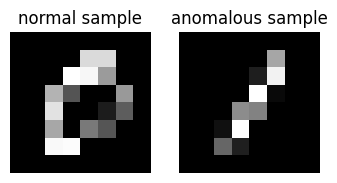

In [7]:
# Visualize data

# Plot the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4, 2))

ax1.imshow(np.reshape(normal_data_np[0], (8,8)), cmap="gray")
ax1.set_title('normal sample')
ax1.axis('off')

ax2.imshow(np.reshape(anomalous_data_np[4], (8,8)), cmap="gray")
ax2.set_title('anomalous sample')
ax2.axis('off')

plt.show()

In [8]:
# Define train set size, the rest will be used for test
train_size = 5000

train_set = torch.tensor(normal_data_np[0:train_size])
normal_data_test = torch.tensor(normal_data_np[train_size:])
anomalous_data_test = torch.tensor(anomalous_data_np)

print("Len train set: ", len(train_set))
print("Len test set: ", len(normal_data_test))

Len train set:  5000
Len test set:  1903


**QAE architecture:**

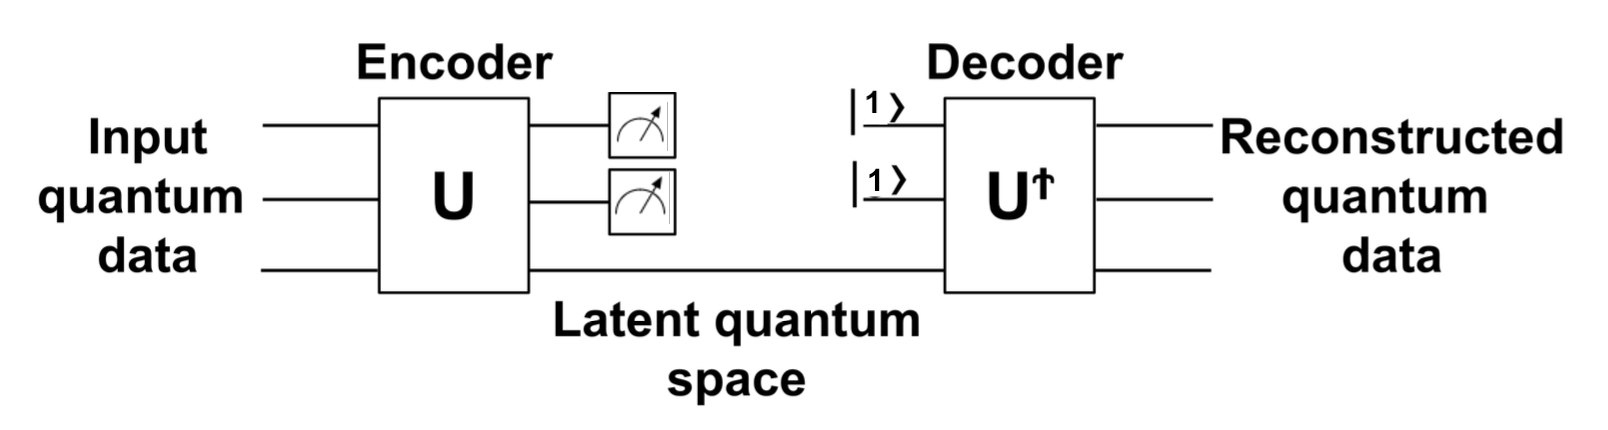

In [9]:
from IPython.display import Image
Image('http://giagu.web.cern.ch/giagu/CERN/QAE.png', width=700)

In [10]:
# Define a quantum device (eg the number of qubits in the circuit)

NUM_QUBITS = 6 # we need 6 quibit to encode 64 pixels (8x8=64=2^6)

# define the quantum device:
dev = qml.device("default.qubit", wires=NUM_QUBITS) #"default.qubit" is the default pennylane differentiable quantum device simulator that is capable of backprop derivatives

# definition of the quantum parametric circuit for the encoder architecture
# the circuit ansatz is made by n_layers of the same unitary block made of a 3 parametric rotations gates(along X, Y and Z) in the block sphere for each qubit, folloeed by a ladder of CNOT
# gates to entangle the qubits, the final rotation applys only on some of the qubits that are the one that will be discarded (compressed)


# helper function defining the quantum circuit for the encoder architecture
def encoder_architecture(params, n_layers, n_qubits, q_compression):
  index = 0
  for i in range(n_layers):

      # Rotation layer
      for j in range(n_qubits):
          qml.RX(params[index], wires=j)
          qml.RY(params[index + 1], wires=j)
          qml.RZ(params[index + 2], wires=j)
          index += 3

      # Entangling layer
      for j in range(n_qubits):
          qml.CNOT(wires=[j, (j + 1) % n_qubits])

  # Final rotations on the discarded (compressed) qubits
  for j in range(q_compression):
      qml.RX(params[index], wires=j)
      qml.RY(params[index + 1], wires=j)
      qml.RZ(params[index + 2], wires=j)
      index += 3

# Quantum encoder pipeline
@qml.qnode(dev, interface='torch')
def encoder(params, state, return_state=False, n_layers = 3, n_qubits = 6, q_compression = 3):

    # Prepare initial state (ok in simulation, allows to skip quantum encoding of the classical data,
    # requires the input to be pre-normalized as a quantum state)
    qml.QubitStateVector(state, wires=range(n_qubits))

    # Real quantum encoding (using amplitude encoding). If you want to use it comment previous line and uncomment this ...
    #qml.AmplitudeEmbedding(features=state, wires=range(n_qubits))

    # Quantum circuit
    encoder_architecture(params, n_layers, n_qubits, q_compression)

    if return_state:
      return qml.state()

    # Return the Z expectation values for the compressed qubits
    # NOTE: we minimize this values that are 1: |0> or -1: |1>. So minimizing implies to force the qubit to be |1>
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(q_compression)]

In [11]:
# Hyper-parameters of the autoencoder
n_layers = 4
n_qubits = 6
q_compression = 3

# Initialize parameters
n_params = (n_layers * n_qubits + q_compression) * 3
params = Variable(torch.normal( mean=0. , std=0.1, size=(n_params,)), requires_grad=True)

# Set the state to the first event of the training set
state = train_set[0]

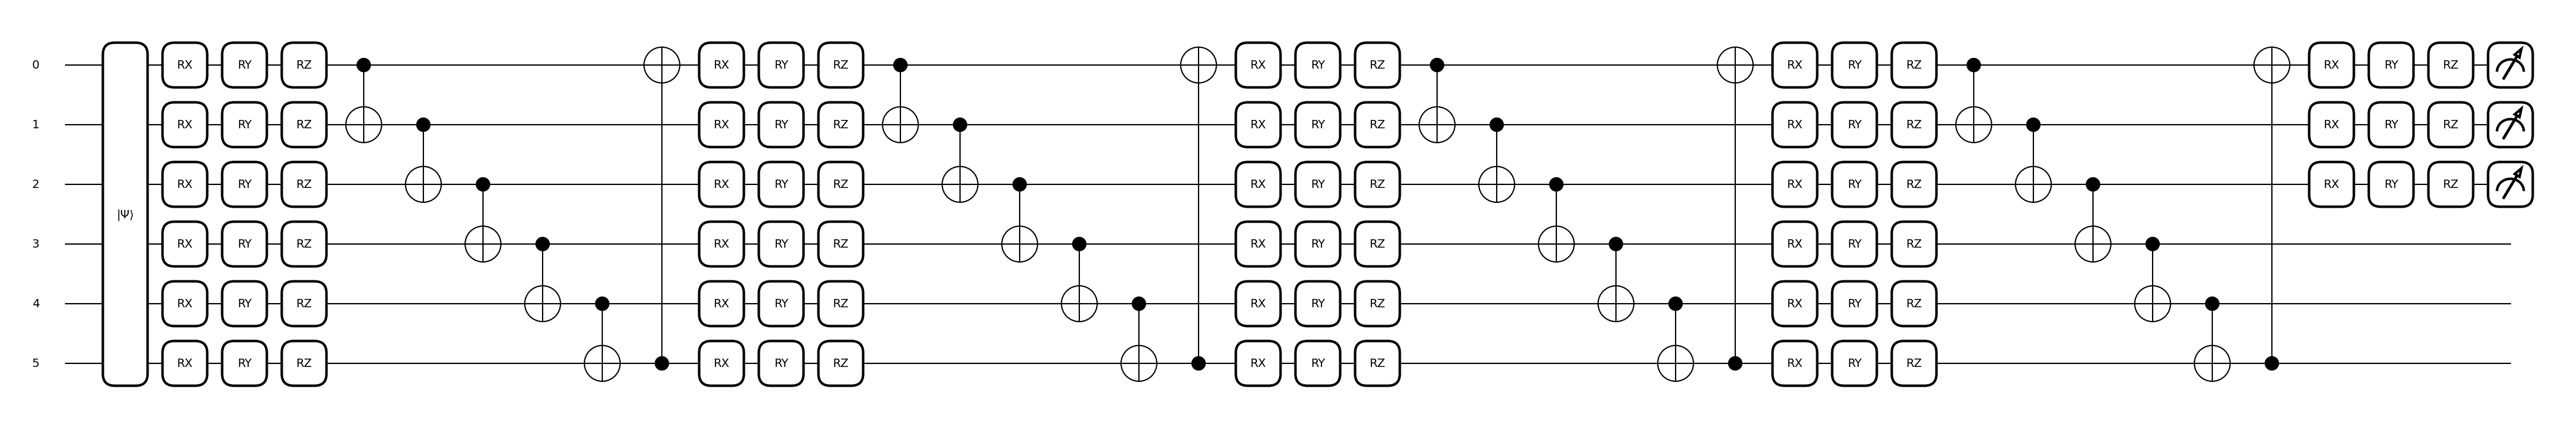

In [12]:
# visualize the encoder

qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(encoder)(params, state, False, n_layers, n_qubits, q_compression)
plt.show()

In [13]:
# Training hyperparameters
epochs = 10
batch_size = 64
steps_per_epoch = int(train_size/batch_size)
optimizer = torch.optim.Adam([params], lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1 , gamma=0.7)

# dataloader
data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

loss_history = []
params_history = []

# Training Loop
for epoch in range(epochs):
  tot_loss = 0.
  for batch in data_loader:
    optimizer.zero_grad()
    batch = batch.type(torch.float).to(device='cuda:0')
    expvals = encoder(params, batch, False, n_layers, n_qubits, q_compression)
    loss = expvals[0].mean() + expvals[1].mean() + expvals[2].mean()
    loss.backward()
    optimizer.step()
    tot_loss += loss.cpu().detach().numpy()
  loss_history.append(tot_loss/steps_per_epoch)
  params_history.append(params)
  scheduler.step()
  print("Epoch {}: avg_loss = {}".format(epoch+1, tot_loss/steps_per_epoch))

Epoch 1: avg_loss = -1.6293419168908327
Epoch 2: avg_loss = -2.0043146935920677
Epoch 3: avg_loss = -2.155040051936969
Epoch 4: avg_loss = -2.1604640597708147
Epoch 5: avg_loss = -2.1623227174710244
Epoch 6: avg_loss = -2.163636742726876
Epoch 7: avg_loss = -2.1638597520079483
Epoch 8: avg_loss = -2.1643688628649285
Epoch 9: avg_loss = -2.1647414146222546
Epoch 10: avg_loss = -2.165651790814501


In [14]:
# Evaluation of performance on test data

test_set_size = len(normal_data_test)
print("Test set size: ", test_set_size)

normal_data_loader = torch.utils.data.DataLoader(normal_data_test, batch_size=256, shuffle=False, drop_last=False)
anomalous_data_loader = torch.utils.data.DataLoader(anomalous_data_test[0:len(normal_data_test)], batch_size=256, shuffle=False, drop_last=False)
loss_s = np.asarray([])
loss_a = np.asarray([])

with torch.no_grad():
    # Standard data
    for batch in normal_data_loader:
      batch = batch.type(torch.float).to(device='cuda:0')
      expvals = encoder(params, batch, False, n_layers, n_qubits, q_compression)
      loss = expvals[0].cpu().numpy() + expvals[1].cpu().numpy() + expvals[2].cpu().numpy()
      loss_s = np.concatenate([loss_s,loss])
    # Anomalous dat
    for batch in anomalous_data_loader:
      batch = batch.type(torch.float).to(device='cuda:0')
      expvals = encoder(params, batch, False, n_layers, n_qubits, q_compression)
      loss = expvals[0].cpu().numpy() + expvals[1].cpu().numpy() + expvals[2].cpu().numpy()
      loss_a = np.concatenate([loss_a,loss])

Test set size:  1903


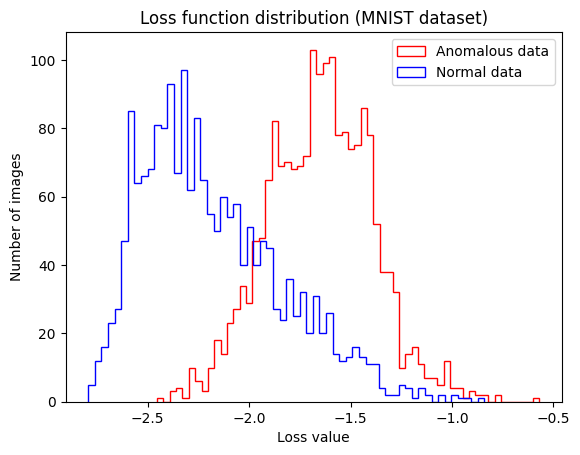

In [15]:
# Loss function plot (we use the loss as anomaly score)
plt.hist(loss_a, bins=60, histtype="step", color="red", label="Anomalous data")
plt.hist(loss_s, bins=60, histtype="step", color="blue", label="Normal data")
plt.ylabel("Number of images")
plt.xlabel("Loss value")
plt.title("Loss function distribution (MNIST dataset)")
plt.legend()
#file_plot = "loss_distribution.png"
#plt.savefig(file_plot)
plt.show()
plt.close()

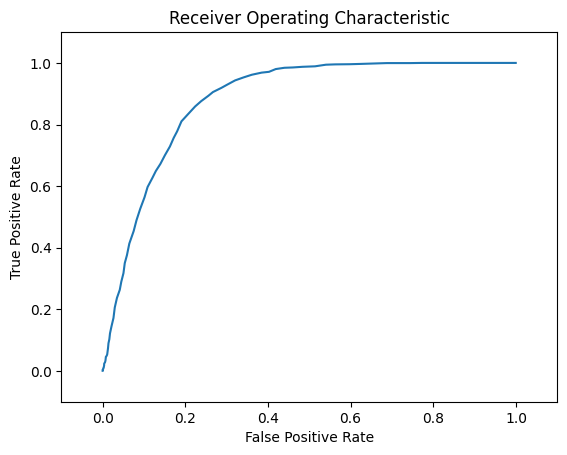

In [16]:
# Compute and Plot the ROC Curve
max1 = np.amax(loss_s)
max2 = np.amax(loss_a)
ma = max(max1, max2)
min1 = np.amin(loss_s)
min2 = np.amin(loss_a)
mi = min(min1, min2)

tot_neg = len(loss_s)
tot_pos = len(loss_a)

n_step = 100.0
n_step_int = 100
step = (ma - mi) / n_step
fpr = []
tpr = []
for i in range(n_step_int):
    treshold = i * step + mi
    c = 0
    for j in range(tot_neg):
        if loss_s[j] > treshold:
            c += 1
    false_positive = c / float(tot_neg)
    fpr.append(false_positive)
    c = 0
    for j in range(tot_pos):
        if loss_a[j] > treshold:
            c += 1
    true_positive = c / float(tot_pos)
    tpr.append(true_positive)

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
#file_plot = "ROC.png"
#plt.savefig(file_plot)
plt.show()
plt.close()

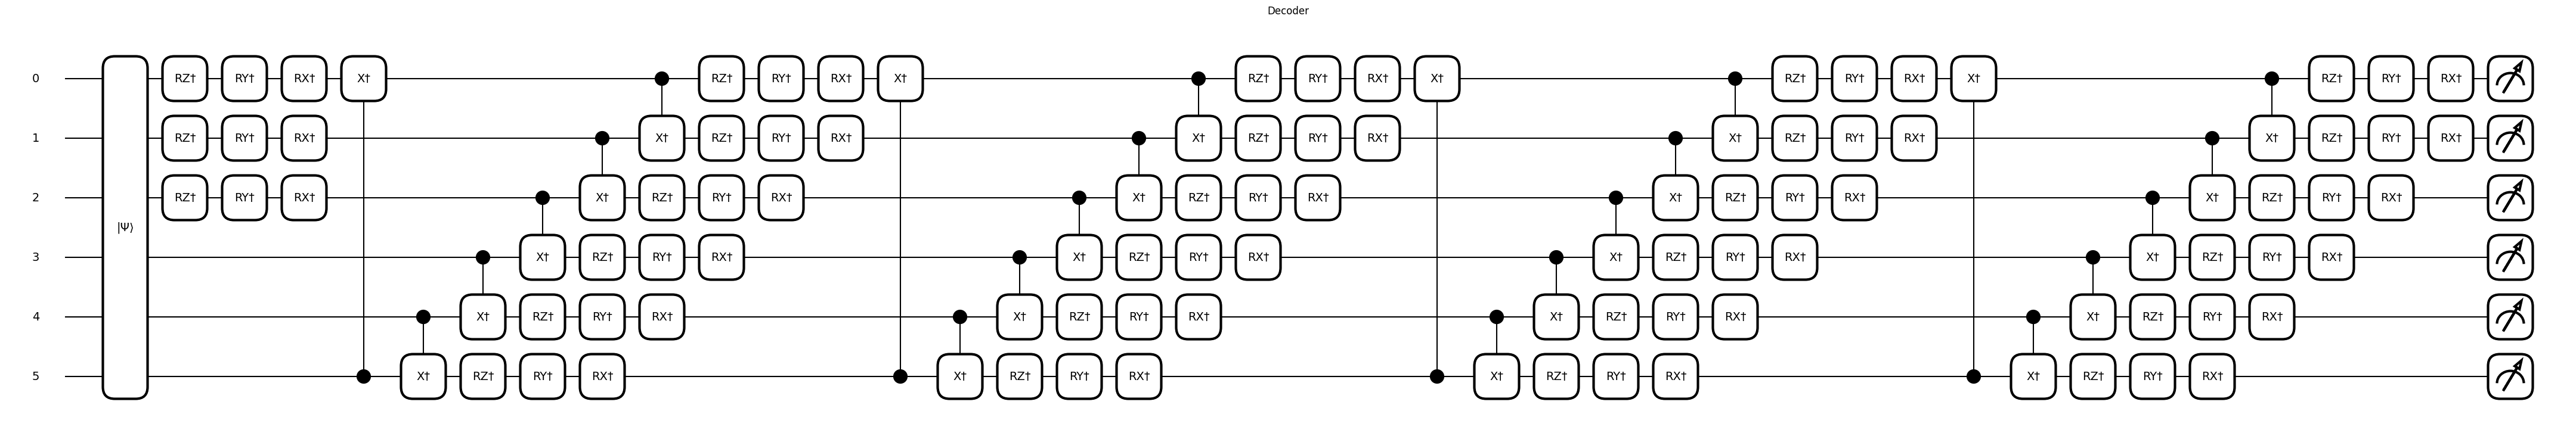

In [17]:
# Decoder
# we can simply obtain the Decoder as adjoint (eg transpose conjugate) of the encoder unitary

@qml.qnode(dev, interface='torch')
def decoder(params, state, n_layers, n_qubits, q_compression):
    # Prepare initial state
    qml.QubitStateVector(state, wires=range(n_qubits))

    # Real quantum encoding (using amplitude encoding). If you want to use it comment previous line and uncomment this ...
    #qml.AmplitudeEmbedding(features=state, wires=range(n_qubits))


    # Quantum circuit (encoder inverse)
    qml.adjoint(encoder_architecture)(params,  n_layers, n_qubits, q_compression) #qml.adjoint compute the transpose conjugate to an input unitary
    return qml.state()

def prepare_decoder_input(latent_space):
  decoder_input = np.zeros((64,), dtype=complex)
  decoder_input[-len(latent_space):] = latent_space
  # Normalize
  norm = np.linalg.norm(decoder_input)
  decoder_input = decoder_input/norm
  return torch.tensor(decoder_input)

# Visualize_decoder
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(decoder)(params, normal_data_test[0], n_layers, n_qubits, q_compression)
plt.title("Decoder")
plt.show()
plt.close()

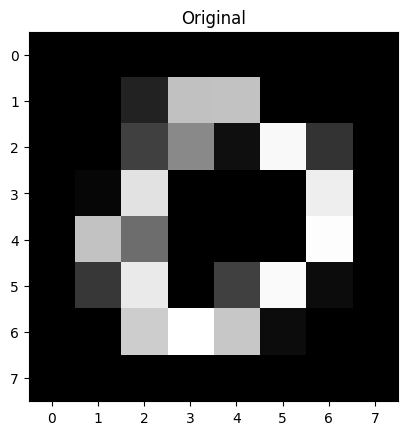

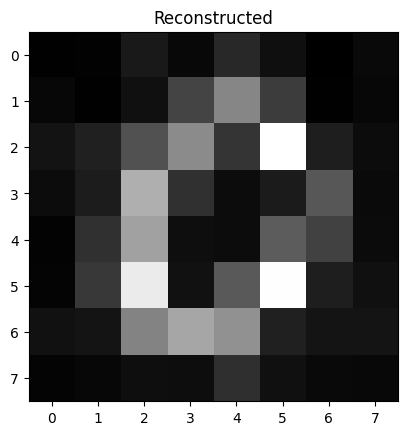

In [18]:
# example on how to use the full outencoder to reconstruct examples

compression = 56 # for 3 out of 6 compressed qubits: compression = 2^5+2^4+2^3
sample = normal_data_test[0] # reconstruct 0
#sample = anomalous_data_test[0] #reconstruct 1
plt.imshow(np.reshape(sample, (8,8)), cmap="gray")
plt.title("Original")
plt.show()
plt.close()
with torch.no_grad():
  final_state = encoder(params=params, state=sample, return_state=True, n_layers=n_layers, n_qubits=n_qubits, q_compression=q_compression).cpu().numpy()
  latent_space = final_state[compression:]
  decoder_input = prepare_decoder_input(latent_space)
  decoder_input = decoder_input.to(device='cuda:0')
  reconstructed = np.absolute(decoder(params, decoder_input, n_layers, n_qubits, q_compression).cpu().numpy())
plt.imshow(np.reshape(reconstructed, (8,8)), cmap="gray")
plt.title("Reconstructed")
plt.show()
plt.close()